This example shows how to perform a geometry optimization of a water molecule and compute
the vibrational normal modes using GFN1-xTB. 

If you do not have
a DFTB license, remove the line with DFTB settings and instead set
``settings.input.ForceField.Type = 'UFF'``

## Initial imports

These two lines are not needed if you run PLAMS using the ``$AMSBIN/plams`` program. They are only needed if you use ``$AMSBIN/amspython``.

In [2]:
from scm.plams import *
init()

PLAMS working folder: /home/hellstrom/adfhome/scripting/scm/plams/doc/source/examples/plams_workdir


## Initial structure

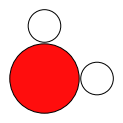

In [21]:
# You could also load the geometry from an xyz file: 
# molecule = Molecule('path/my_molecule.xyz')
# or generate a molecule from SMILES:
# molecule = from_smiles('O')
molecule = Molecule()
molecule.add_atom(Atom(symbol='O', coords=(0,0,0)))
molecule.add_atom(Atom(symbol='H', coords=(1,0,0)))
molecule.add_atom(Atom(symbol='H', coords=(0,1,0)))

plot_molecule(molecule)

## Calculation settings

The calculation settings are stored in a ``Settings`` object, which is a type of nested dictionary.

In [22]:
settings = Settings()
settings.input.ams.Task = 'GeometryOptimization'
settings.input.ams.Properties.NormalModes = 'Yes'
settings.input.DFTB.Model = 'GFN1-xTB'
#settings.input.ForceField.Type = 'UFF' # set this instead of DFTB if you do not have a DFTB license. You will then not be able to extract the HOMO and LUMO energies.

## Create an AMSJob

In [5]:
job = AMSJob(molecule=molecule, settings=settings, name='water_optimization')

You can check the input to AMS by calling the ``get_input()`` method:

In [6]:
print("-- input to the job --")
print(job.get_input())
print("-- end of input --")

-- input to the job --
Properties
  NormalModes Yes
End

Task GeometryOptimization

system
  Atoms
              O       0.0000000000       0.0000000000       0.0000000000 
              H      -0.7000000000      -0.7000000000       0.0000000000 
              H       0.0000000000       1.0000000000       0.0000000000 
  End
End

Engine DFTB
  Model GFN1-xTB
EndEngine


-- end of input --


## Run the job

In [7]:
job.run();

[23.01|18:33:14] JOB water_optimization STARTED
[23.01|18:33:14] JOB water_optimization RUNNING
[23.01|18:33:16] JOB water_optimization FINISHED
[23.01|18:33:16] JOB water_optimization SUCCESSFUL


## Main results files: ams.rkf and dftb.rkf

The paths to the main binary results files ``ams.rkf`` and ``dftb.rkf`` can be retrieved as follows:

In [8]:
print(job.results.rkfpath(file='ams'))
print(job.results.rkfpath(file='engine'))

/home/hellstrom/adfhome/scripting/scm/plams/doc/source/examples/plams_workdir/water_optimization/ams.rkf
/home/hellstrom/adfhome/scripting/scm/plams/doc/source/examples/plams_workdir/water_optimization/dftb.rkf


## Optimized coordinates

Optimized coordinates
---------------------
  Atoms: 
    1         O       0.114377      -0.043562       0.000000 
    2         H      -0.701941      -0.542102       0.000000 
    3         H      -0.112436       0.885664       0.000000 

---------------------


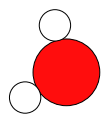

In [9]:
optimized_molecule = job.results.get_main_molecule()

print("Optimized coordinates")
print("---------------------")
print(optimized_molecule)
print("---------------------")
plot_molecule(optimized_molecule) # show molecule in a Jupyter notebook

## Optimized bond lengths and angle

Unlike python lists, where the index of the first element is 0, 
the index of the first atom in the molecule object is 1.

In [20]:
bond_length = optimized_molecule[1].distance_to(optimized_molecule[2])
print('O-H bond length: {:.3f} angstrom'.format(bond_length))

O-H bond length: 0.957 angstrom


In [19]:
bond_angle = optimized_molecule[1].angle(optimized_molecule[2], optimized_molecule[3])
print('Bond angle  : {:.1f} degrees'.format(Units.convert(bond_angle, 'rad', 'degree')))

Bond angle  : 107.7 degrees


## Calculation timing

In [11]:
timings = job.results.get_timings()

print("Timings")
print("-------")
for key, value in timings.items():
    print(f'{key:<20s}: {value:.3f} seconds')
print("-------")

Timings
-------
elapsed             : 1.808 seconds
system              : 0.036 seconds
cpu                 : 1.538 seconds
-------


## Energy

In [12]:
energy = job.results.get_energy(unit='kcal/mol')

print('Energy      : {:.3f} kcal/mol'.format(energy))

Energy      : -3618.401 kcal/mol


## Vibrational frequencies

In [13]:
frequencies = job.results.get_frequencies(unit='cm^-1')

print("Frequencies")
print("-----------")
for freq in frequencies:
    print(f'{freq:.3f} cm^-1')
print("-----------")

Frequencies
-----------
1426.920 cm^-1
3671.233 cm^-1
3783.195 cm^-1
-----------


##  Dipole moment

In [14]:
import numpy as np
try:    
    dipole_moment = np.linalg.norm(np.array(job.results.get_dipolemoment()))
    dipole_moment *= Units.convert(1.0, 'au', 'debye')
    print('Dipole moment: {:.3f} debye'.format(dipole_moment))
except KeyError:
    print("Couldn't extract the dipole moment")

Dipole moment: 1.827 debye


## HOMO, LUMO, and HOMO-LUMO gap

Note: The methods for extracting HOMO, LUMO, and HOMO-LUMO gap only exist in AMS2023 and later.

In [15]:
try:
    homo = job.results.get_homo_energies(unit='eV')[0]
    lumo = job.results.get_lumo_energies(unit='eV')[0]
    homo_lumo_gap = job.results.get_smallest_HOMO_LUMO_gap(unit='eV')
    
    print('HOMO        : {:.3f} eV'.format(homo))
    print('LUMO        : {:.3f} eV'.format(lumo))
    print('HOMO-LUMO gap : {:.3f} eV'.format(homo_lumo_gap))
except AttributeError:
    print("Methods to extract HOMO and LUMO require AMS2023 or later")
except KeyError:
    print("Couldn't extract the HOMO and LUMO.")

HOMO        : -13.592 eV
LUMO        : -4.205 eV
HOMO-LUMO gap : 9.387 eV


## Read results directly from binary .rkf files

You can also read results directly from the binary .rkf files. Use the "expert mode" of the KFbrowser program that comes with AMS to find out which section and variable to read.

Below, we show how to extract the ``AMSResults%Energy`` variable from the dftb.rkf file. This is the same number that was extracted previously using the ``job.results.get_energy()`` method.

In [16]:
energy = job.results.readrkf('AMSResults', 'Energy', file='engine')
print(f"Energy from the engine .rkf file (in hartree): {energy}")

Energy from the engine .rkf file (in hartree): -5.766288625035975


## Finish PLAMS

The ``finish()`` method is called automatically if you run the script with ``$AMSBIN/plams``. You should only call it if you use ``$AMSBIN/amspython`` to run the script.

In [17]:
finish()

[23.01|18:33:23] PLAMS run finished. Goodbye
